In [7]:
import pandas as pd
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy import integrate

In [8]:
def heston_integrand(S,K,kappa,l,tau,r,q,rho,sigma,theta,phi,vo):
    b1 = kappa + l- rho*sigma
    b2 = kappa + l
    u1=0.5
    u2=-0.5
    a=kappa*theta
    i = complex(0,1.0)
    sigma2=sigma*sigma
    logK = np.log(K)
    logS =np.log(S)
    
    z = rho*sigma*phi*i
    def g(b,d):
        return (b-z-d)/(b-z+d)
    
    def d(b,u):
        return np.sqrt(np.power(b-z,2.0)-sigma2*(2*i*u*phi-phi*phi))
    
    
    def C(b,d,g):
        ratio =  (1.0-g*np.exp(-d*tau))/(1.0-g)
        return (r-q)*i*phi*tau + a/sigma2*((b-z-d)*tau-2.0*np.log(ratio))
        
        
    def D(b,d,g):
        return (b-z-d)/(sigma2)*(1.0-np.exp(-d*tau))/(1.0-g*np.exp(-d*tau))
    
    d1 = d(b1,u1)
    d2 = d(b2,u2)
    g1 = g(b1,d1)
    g2 = g(b2,d2)
    C1 = C(b1,d1,g1)
    C2 = C(b2,d2,g2)
    D1 = D(b1,d1,g1)
    D2 = D(b2,d2,g2)
    
    f1 = (np.exp(C1+D1*vo+i*phi*logS))
    f2 = (np.exp(C2+D2*vo+i*phi*logS))
    
    Ia = np.exp(-i*phi*logK)/(i*phi)*(S*np.exp(-q*tau)*f1-K*np.exp(-r*tau)*f2)
    return Ia.real
    
    

17.87462478594385


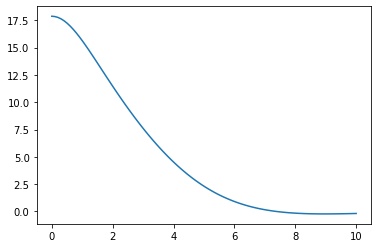

In [9]:
kappa=1.5768
sigma=0.5751
rho = -0.5711
theta=0.0398
vo = 0.0175
K=100.0
S=100.0        
q=0.0
r=0.03
l=0.0
tau=5.0
x=np.linspace(0.0001,10,100)
y = [
    heston_integrand(S=S,K=K,kappa=kappa,l=l,tau=tau,r=r,q=q,
                     rho=rho,sigma=sigma,theta=theta,phi=phi,vo=vo) 
    for phi in x
]
print(y[0])
plt.plot(x,y)
plt.show()


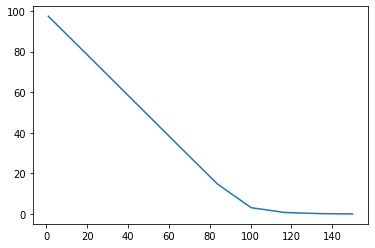

In [10]:
from scipy import integrate

def hestoncall(S,K,kappa,l,tau,r,q,rho,sigma,theta,vo):
    def integrand(phi):
        return heston_integrand(S=S,K=K,kappa=kappa,l=l,tau=tau,r=r,q=q,
                     rho=rho,sigma=sigma,theta=theta,phi=phi,vo=vo)
    I=integrate.quad(integrand,0.001,100)
    return 0.5*S*np.exp(-q*tau)-0.5*K*np.exp(-r*tau)+1.0/np.pi*I[0]


def hestonput(S,K,kappa,l,tau,r,q,rho,sigma,theta,vo):
    return hestoncall(S,K,kappa,l,tau,r,q,rho,sigma,theta,vo)+K*np.exp(-r*tau)-S*np.exp(-q*tau)



kappa=1.5768
sigma=0.5751
rho = -0.5711
theta=0.0398
vo = 0.0175
K=100.0

q=0.0
r=0.03
l=0.0
tau=0.5

x=np.linspace(1,150,10)
y= [hestonput(S,K,kappa,l,tau,r,q,rho,sigma,theta,vo) for S in x]

plt.plot(x,y)
plt.show()

## Quadratic Discretization for MC


### Volatility

Price analytics 10.2015105303926 
K0=0.01085,K1=69.456875,K2=-70.543125,K3=0.0006375,K4=0.0006375,A=-70.54280625
simulating i=0
simulating i=1000
simulating i=2000
simulating i=3000
simulating i=4000


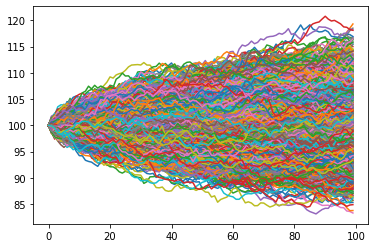

<Figure size 432x288 with 0 Axes>

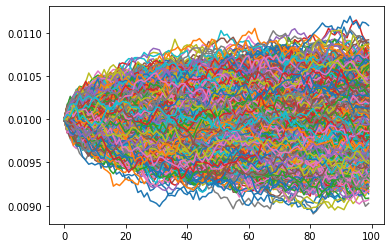

MC=10.324342441443589, 
analytical=10.2015105303926,
rel. error=-1.1897310821260805%
Dollar error -0.122831911050989


In [24]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)
N = 5000
T = 100

np.random.seed(1)
K=90.0
S0 = 100.0
q=0.02
r=0.03
kappa = 6.2
theta = 0.01
sigma = 0.01
rho=-0.7
vo = 0.01

c = hestoncall(S=S0,K=K,kappa=kappa,l=0,tau=0.25,r=r,q=q,rho=rho,sigma=sigma,theta=theta,vo=vo)
print(f"Price analytics {c} ")
dt = 0.25/float(T)


phic = 1.5
sigma2 = sigma * sigma
ekdt = np.exp(-kappa * dt)

gamma_1 = 0.5
gamma_2=0.5

K0 = -kappa *rho* theta / sigma * dt
K1 = (kappa * rho / sigma - 0.5) * gamma_1 * dt - rho / sigma
K2 = (kappa * rho / sigma - 0.5) * gamma_2 * dt + rho / sigma
K3 = (1.0 - rho * rho) * gamma_1 * dt
K4 = (1.0 - rho * rho) * gamma_2 * dt
A = K2 + 0.5 * K4
MC = True
St = np.zeros((N, T))
Vt = np.zeros((N, T))
print(f"K0={K0},K1={K1},K2={K2},K3={K3},K4={K4},A={A}")
for i in range(0, N):
    if i % 1000 == 0:
        print(f"simulating i={i}")
    St[i, 0] = S0
    Vt[i, 0] = vo
    for t in range(1, T):   
        Z1= np.random.randn()
        #Zs = rho*Zv+np.sqrt(1.0-rho*rho)*np.random.normal(0.0, 1.0, 1)
        # QE Algorithm:
        m = theta + (Vt[i, t-1] - theta) * ekdt
        m2 = m * m
        s2 = (Vt[i, t-1] * sigma2 * ekdt / kappa * (1.0 - ekdt) +
              theta * sigma2 / (2 * kappa)
              * (1.0 - ekdt)*(1.0 - ekdt)
              )

        phi = s2 / m2
        
          
        if phi <= phic:
            b = np.sqrt(2.0 / phi - 1.0 + np.sqrt(2.0 / phi * (2.0 / phi - 1)))
            a = m / (1.0 + b * b) 
            Zv = np.random.randn()
            Vt[i, t] = a * (b + Zv)*(b + Zv)
            # martingale correction
            if MC and A < 1.0 / (2.0 * a):
                M = np.exp(A * b * b * a / (1 - 2 * A * a)) / np.sqrt(1 - 2 * A * a)
                K0 = -np.log(M) - (K1 + 0.5 * K3) * Vt[i, t-1]            
        else: 
            Uv = np.random.uniform(1e-6,1.0-1e-6)  
            p = (phi - 1) / (phi + 1)
            beta = (1.0 - p) / m
            if Uv <= p:
                phiinv = 0
            else:
                phiinv = 1.0 / beta * np.log((1 - p) / (1 - Uv))
            Vt[i,t] = phiinv
            # Martingale correction
            if MC == True and A < beta:
                M = p + beta * (1 - p) / (beta - A)
                K0 = -np.log(M) - (K1 + 0.5 * K3) * Vt[i, t-1]
                
        St[i, t] = (St[i, t-1] *
                        np.exp((r - q) * dt + 
                               K0 + 
                               K1 * Vt[i, t - 1] + 
                               K2 * Vt[i, t] + 
                               np.sqrt(K3 * Vt[i, t - 1] + 
                                       K4 * Vt[i, t]) * Z1
                              )
                        )
        
        

frameS = pd.DataFrame(St)
frameS.transpose().plot(legend=None)

plt.figure()
frameV = pd.DataFrame(Vt)
frameV.transpose().plot(legend=None)

plt.show()



payoff = frameS.values[:,-1]-K
payoff[payoff<0]=0.0
cmc = payoff.mean()
print(f"""MC={cmc}, 
analytical={c},
rel. error={(c-cmc)/cmc*100.0}%""")
print(f"Dollar error {c-cmc}")



In [35]:
hestonsim = pd.read_csv('/Users/fran/data/heston_sim_1.csv')

In [46]:
import seaborn as sns
%matplotlib qt
asset="asset"
data0 = hestonsim[hestonsim[asset]==0]
data1 = hestonsim[hestonsim[asset]==1]
data2 = hestonsim[hestonsim[asset]==2]

sns.distplot(data0["ST"],label="heston rho=-70%; sigma=50%")
sns.distplot(data1["ST"],label="heston rho=70%; sigma=50%")
sns.distplot(data2["ST"],label="heston rho=-70%; sigma=15%")
plt.legend()
